Юлия спасибо, что подождали!!!)))

### <a href=#1 id="z" style="color: #000000;text-decoration: none;">1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).</a>

### <a href=#2 style="color: #000000;text-decoration: none;">2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.</a>

### <a href=#3 style="color: #000000;text-decoration: none;">3. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.</a>

### <a href=#4 style="color: #000000;text-decoration: none;"> 4. (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy.</a>

In [213]:
import matplotlib.pyplot as plt
import random
from time import perf_counter
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

In [429]:
def time_(func):
    def r(*args, **kwargs):
        t_start= perf_counter()
        result = func(*args, **kwargs)
        t_stop = perf_counter()     
        result_time = t_stop - t_start
        print(f'time {func.__name__}: {result_time*1000:.3f} ms')
        return result
    return r

#Реализуем генерацию  𝑁  бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []
    
    for i in range(N):
        
        sample_index = np.random.randint(0, n_samples, size=n_samples)
        b_data = data[sample_index]
        b_labels = labels[sample_index]
        
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = list(range(len_sample))
    len_subsample = int(np.sqrt(len_sample))    
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)
    return subsample

# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

        

 # И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 

# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity    

# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле

def split(data, labels, column_index, t):
    
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
        
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
#             if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
#                 continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


#Теперь добавим функцию формирования случайного леса.
@time_
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
#     print(predictions)

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
#     print(predictions_per_object)

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions


# Функция классификации отдельного объекта

def classify_object(obj, node):
    
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction        
        return answer
    try:
        if obj[node.index] <= node.t:
            return classify_object(obj, node.true_branch)
        else:
            return classify_object(obj, node.false_branch)
    except  AttributeError:
        answer = node.prediction        
        return answer




# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0



### <div id=1> 1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках</div>
<div style="text-align:right;"><a href=#z style="color: #000000;"><button style="color: bleak;">наверх...</button></a></div>



In [582]:
# сгенерируем данные, представляющие собой 100 объектов с 5-ю признаками
classification_data, classification_labels = make_classification(n_samples=200,
                                                                 n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0, 
                                                                 n_clusters_per_class=1, random_state=35)

In [583]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [584]:
@time_
def algorithm_accuracy(train_data, train_labels, n_trees):    
    my_forest_1 = random_forest(train_data, train_labels, n_trees)

    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest_1, train_data)

    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest_1, test_data)

    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')
    return my_forest_1,train_accuracy,test_accuracy

In [600]:
#обучение с разным количеством случайных деревьев
n_trees = [1,3,10,50,100,300,400,500]
#n_trees = [1,3,10]
list_trees = []
for item in n_trees:
    a = [item]+list(algorithm_accuracy(train_data, train_labels, item))    
    list_trees.append(a)
list_trees = np.array(list_trees)
list_trees[:,2:4]

time random_forest: 32.808 ms
Точность случайного леса из 1 деревьев на обучающей выборке: 94.286
Точность случайного леса из 1 деревьев на тестовой выборке: 81.667
time algorithm_accuracy: 33.672 ms
time random_forest: 63.142 ms
Точность случайного леса из 3 деревьев на обучающей выборке: 98.571
Точность случайного леса из 3 деревьев на тестовой выборке: 95.000
time algorithm_accuracy: 64.556 ms
time random_forest: 169.741 ms
Точность случайного леса из 10 деревьев на обучающей выборке: 100.000
Точность случайного леса из 10 деревьев на тестовой выборке: 98.333
time algorithm_accuracy: 173.370 ms
time random_forest: 791.066 ms
Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой выборке: 98.333
time algorithm_accuracy: 810.280 ms
time random_forest: 1514.951 ms
Точность случайного леса из 100 деревьев на обучающей выборке: 100.000
Точность случайного леса из 100 деревьев на тестовой выборке: 98.333
time algorithm_acc

array([[94.28571428571428, 81.66666666666667],
       [98.57142857142858, 95.0],
       [100.0, 98.33333333333333],
       [100.0, 98.33333333333333],
       [100.0, 98.33333333333333],
       [100.0, 98.33333333333333],
       [100.0, 98.33333333333333],
       [100.0, 98.33333333333333]], dtype=object)

С ростом количества деревьев accuracy metric улучшается, но начиная с некоторого значения(n_trees = 50) она не меняется.

In [608]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [606]:
def plots(train_data, forest_):    
    forest = forest_[1]
    train_accuracy = forest_[2]
    test_accuracy = forest_[3]    
    n_trees = len(forest)
    colors = ListedColormap(['red', 'blue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])
    # график обучающей выборки

    plt.figure(figsize = (16, 7))
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'n_trees={n_trees}, Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'n_trees={n_trees}, Test accuracy={test_accuracy:.2f}')

_Визуализируем разделяющие гиперплоскости на графиках для каждого леса из n деревьев_ 

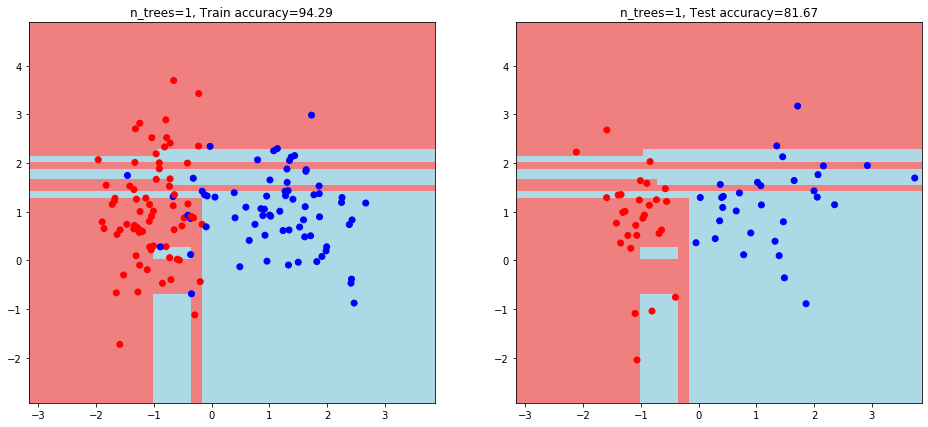

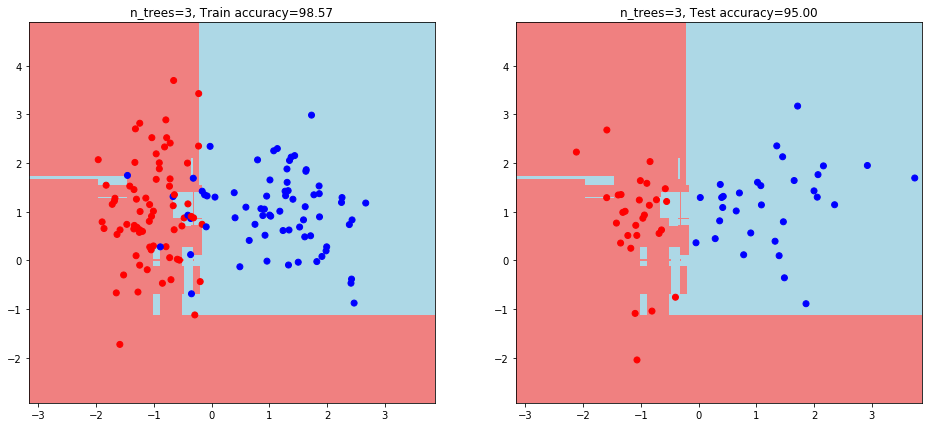

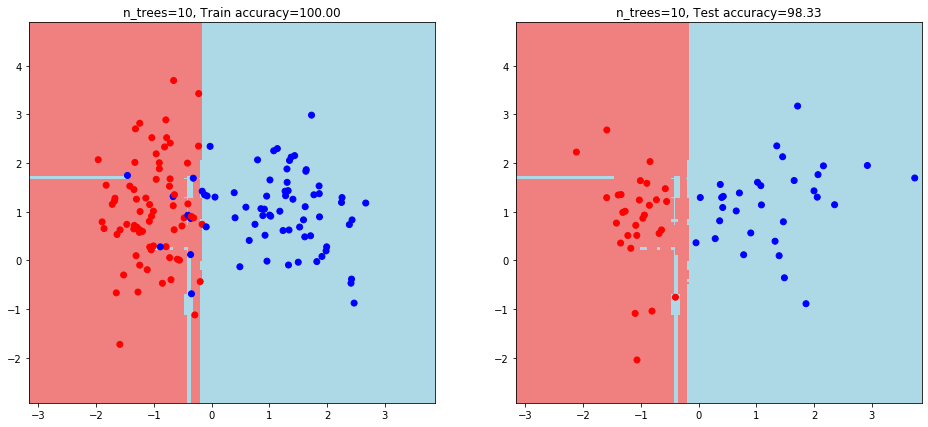

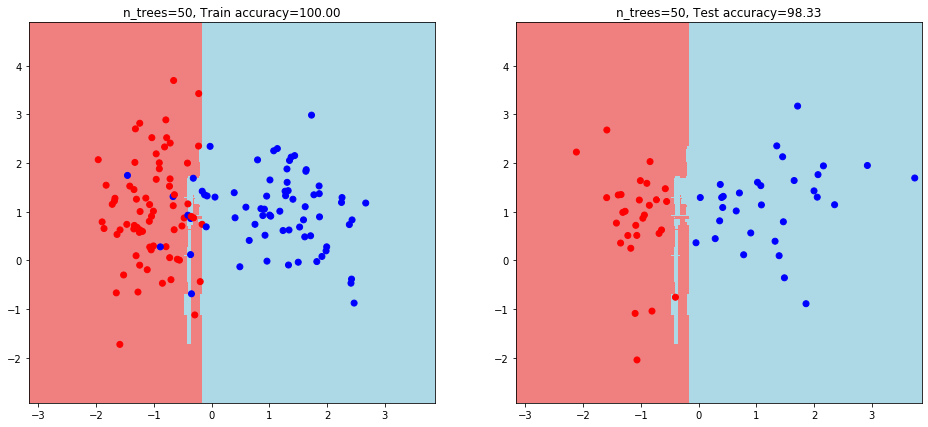

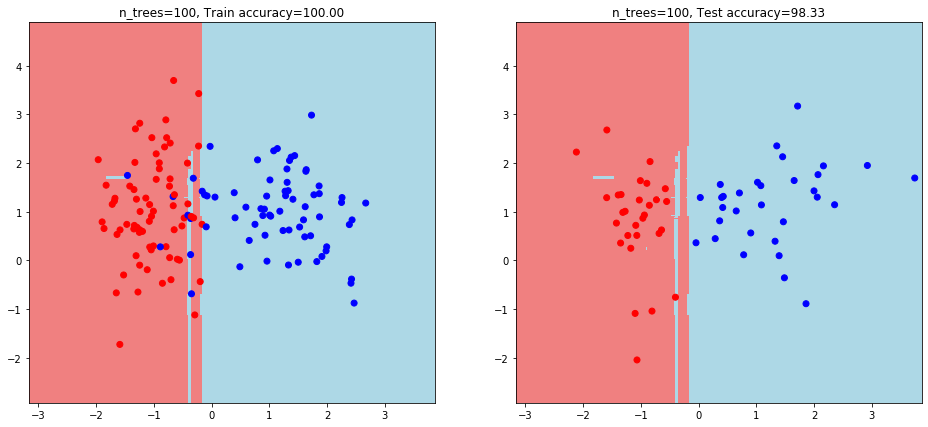

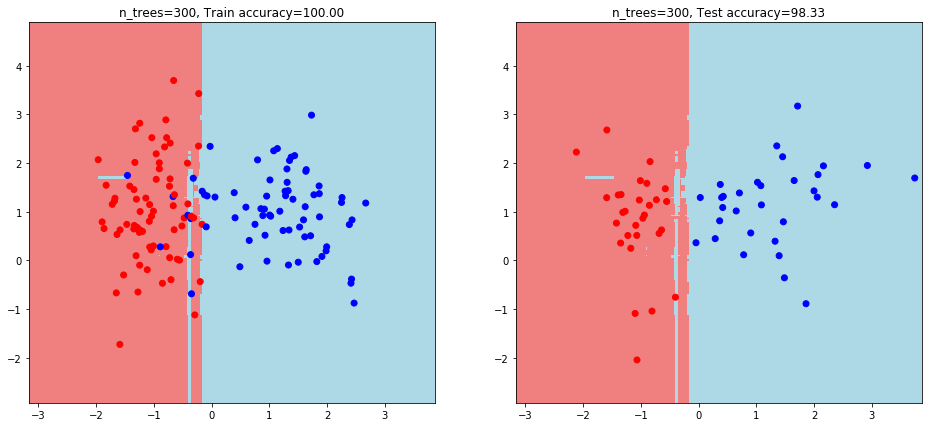

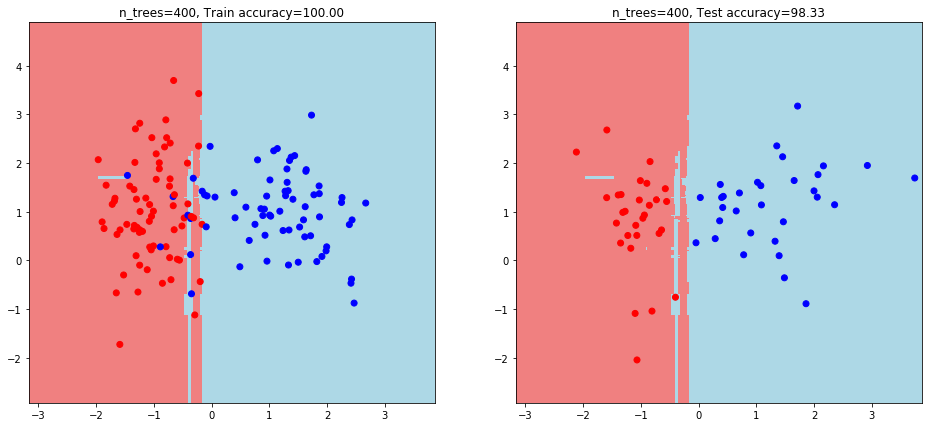

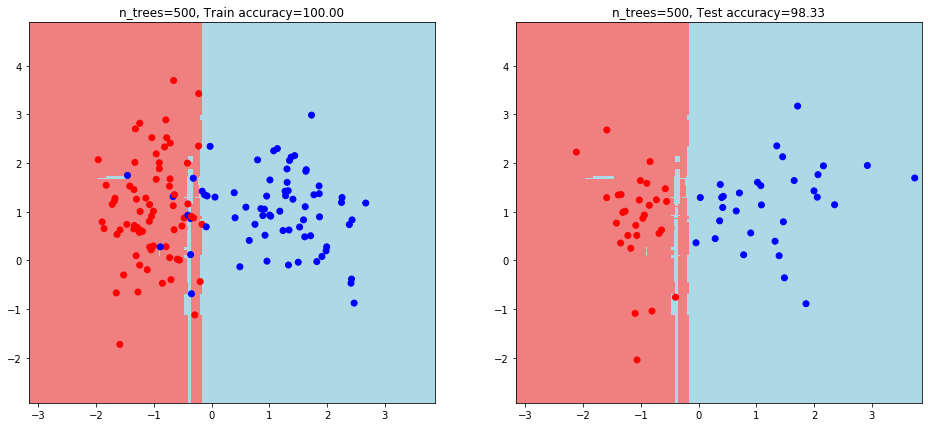

In [607]:
for item_list_trees in list_trees:  
    plots(train_data, item_list_trees)

### <div id=2>2.Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем</div>
<div style="text-align:right;"><a href=#z style="color: #000000;"><button style="color: bleak;">наверх...</button></a></div>

*Модель при trees = 1 имеет хорошие значения метрики как на обучающей выборке так и на тестовой, из графика видно, что при n trees =1 модель не дообучилась. При trees = 3 модель улучшает свою метрику, по графику можно сделать вывод, что модель обучилась. При trees = 10 значения метрики улучшились за счет различение объектов расположенных близко друг к другу. Сложно сказать, что модель переобучилась, так сама структура данных этому не способствует(не сложная). Так же стоит заметить,что при trees более 10 значения метрики модели не меняюся, следовательно для построения качественной модели не требуется большого количества деревьев. В нашем случаее достаточно 10.*

### <div id=3>3. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.</div>
<div style="text-align:right;"><a href=#z style="color: #000000;"><button style="color: bleak;">наверх...</button></a></div>

In [434]:
# Изменим класс узла, добавив в него свойство sample_bootstrap, 
# в котором будет храниться бутстрап выборка на которой текущее дерево обучалось

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        #Здесь будет хранится бутстрап выборка на которой текущее дерево обучалось
        self.sample_bootstrap = []

       

In [435]:
#Теперь добавим функцию формирования случайного леса.
@time_
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        result = build_tree(b_data, b_labels)        
        result.sample_bootstrap = b_data #добавляем бутстрап выборку на которой текущее дерево обучалось
        forest.append(result)        
    return forest

In [442]:
n_trees = 10
n_trees_1 = algorithm_accuracy(train_data, train_labels, n_trees)

time random_forest: 53.661 ms
Точность случайного леса из 10 деревьев на обучающей выборке: 98.571
Точность случайного леса из 10 деревьев на тестовой выборке: 86.667
time algorithm_accuracy: 55.132 ms


In [453]:
def Out_of_Bag(forest):
    no_obj_sample = []
    err_label = []
    for key, obj in enumerate(train_data):
        s = 0
        for tree in forest:
            sample_bootstrap = tree.sample_bootstrap
            if np.isclose(sample_bootstrap, obj).any():                
                continue
            no_obj_sample += [tree]
        if no_obj_sample : # Если no_obj_sample оказался пустым, то это означает, что проверяемый пример obj оказался во всех выборках bootstrap
            train_answers = tree_vote(no_obj_sample, [obj])
            err_label += [train_ansn_treeswers + [train_labels[key]]]
        no_obj_sample = []
    return np.array(err_label)    

In [456]:
y = Out_of_Bag(n_trees_1[0])
accuracy_metr = accuracy_metric(y[:,0],y[:,1])
print(f"Точность случайного леса из {n_trees} деревьев, оцененной методом Out_of_Bag   {accuracy_metr}")

Точность случайного леса из 10 деревьев, оцененной методом Out_of_Bag   89.85507246376811


### <div id=4>4. (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy</div>
<div style="text-align:right;"><a href=#z style="color: #000000;"><button style="color: bleak;">наверх...</button></a></div>

In [293]:
# Критерий энтропия Шеннона

def entropy(labels):    
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    res = 0
    for label in classes:
        p = classes[label] / len(labels)
        res += p*np.log2(p) 
    return -res